In [1]:
import sys
sys.path.append('..')

from data.tile_stitcher import stitch_predictions


In [2]:
# ckpt = '2410/Hagen-joint_indi-l1/36'
# ckpt  = '2412/HT_LIF-joint_indi-l1/8'
# ckpt = '2501/COSEM_jrc-hela-joint_indi-l1/32'
ckpt = '2501/COSEM_jrc-hela-joint_indi-l1/13'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'
num_timesteps = 1
enable_real_input = True


ckpt = ckpt.strip('/').strip(' ')
ckpt

'2501/COSEM_jrc-hela-joint_indi-l1/13'

In [3]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train", "distributed"]
    output = {}
    for k in keys:
        if k in opt:
            output[k] = opt[k]['value']
    return output

In [4]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
print(opt['path']['resume_state'])

opt['model']['beta_schedule']['val']['n_timestep'] = num_timesteps
if opt['datasets']['train']['name'] == 'COSEM_jrc-hela':
    pass

elif opt['datasets']['train']['name'] == 'hagen':
    opt['datasets']['val']['datapath'] = {
    'ch0': '/group/jug/ashesh/data/diffsplit_hagen/test/test_actin-60x-noise2-highsnr.tif',
    'ch1': '/group/jug/ashesh/data/diffsplit_hagen/test/test_mito-60x-noise2-highsnr.tif'
    }

/group/jug/ashesh/training/diffsplit/2501/COSEM_jrc-hela-joint_indi-l1/13/checkpoint/I950000_E3959


In [5]:
if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

In [6]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt, tiled_pred=True)

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

# load checkpoint
diffusion.load_network()

INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.0 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


Read from /group/jug/ashesh/bleedthroughsimulation/jrc_hela-3/train-val-test-split/train_jrc_hela-3_bleedthrough_EGFP_Venus_R3.0_S4_D1_Ex100.0ms.tif (96, 700, 1400, 3)
Using first 0/96 for real input
Computing mean and std for normalization


INFO:base:Initialization method [orthogonal]


[SplitDataset] Data: 96x3x(700, 1400) Patch:256 Random:1 Aug:True Q:0.995 UpperClip:0Uncor:False RealFraction:0.0 InpFrmNormTar
Read from /group/jug/ashesh/bleedthroughsimulation/jrc_hela-3/train-val-test-split/val_jrc_hela-3_bleedthrough_EGFP_Venus_R3.0_S4_D1_Ex100.0ms.tif (96, 700, 700, 3)
[TilingDataset] Data: 96x3x(700, 700) Patch:256 Random:0 Aug:False Q:0.995 UpperClip:0Uncor:False InpFrmNormTar
[IndiFullTranslation]: Sampling mode: linear_indi, Noise mode: gaussian
[IndiFullTranslation]: Sampling mode: linear_indi, Noise mode: gaussian
[JointIndi]: w_input_loss: 0.1 With Time Predictor


INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2501/COSEM_jrc-hela-joint_indi-l1/13/checkpoint/I950000_E3959] ...


Scheduler set to ReduceLROnPlateau with patience:  100


INFO:base:Model [DDPM] is created.
INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2501/COSEM_jrc-hela-joint_indi-l1/13/checkpoint/I950000_E3959] ...



--------------------------------------------------
Number of trainable parameters: 7.30M
--------------------------------------------------



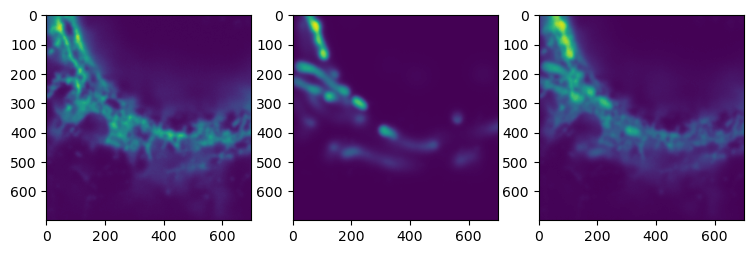

In [7]:
import matplotlib.pyplot as plt 

_,ax = plt.subplots(figsize=(9,3), ncols=3)
ax[0].imshow(val_set._data_dict[0][48])
ax[1].imshow(val_set._data_dict[1][48])
ax[2].imshow(val_set._data_dict[2][48])

In [8]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd


# w_list = np.arange(0,1, 0.2)
# stats = {w: defaultdict(list) for w in w_list}
# for w in w_list:
#     for i in range(len(val_set)):
#         data_dict = val_set[i]
#         inp = (1-w) * data_dict['target'][:1] + w * data_dict['target'][1:]
#         stats[w]['min'].append(inp.min())
#         stats[w]['max'].append(inp.max())
#         stats[w]['mean'].append(inp.mean())
#         stats[w]['std'].append(inp.std())
    

# _,ax = plt.subplots(figsize=(18,3),ncols=4)
# for w in w_list:
#     ax[0].plot(pd.Series(stats[w]['min']).rolling(20).mean(), label=f't={w:.1f}')
#     ax[1].plot(pd.Series(stats[w]['max']).rolling(20).mean(), label=f't={w:.1f}')
#     ax[2].plot(pd.Series(stats[w]['mean']).rolling(20).mean(), label=f't={w:.1f}')
#     ax[3].plot(pd.Series(stats[w]['std']).rolling(20).mean(), label=f't={w:.1f}')
# ax[0].legend()
# ax[0].set_title('min')
# ax[1].set_title('max')
# ax[2].set_title('mean')
# ax[3].set_title('std')

-0.2340082 3.7022364 -0.18122524 3.9379263 -0.21169817 5.4633036


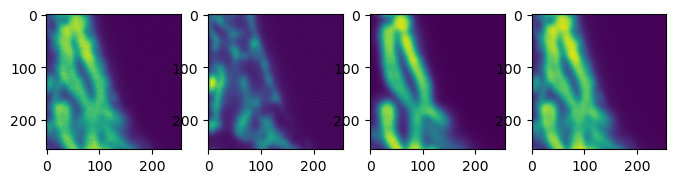

In [9]:
import matplotlib.pyplot as plt

data= val_set[0]
inp = data['input']
target = data['target']
inp = inp.transpose(1,2,0)
target = target.transpose(1,2,0)
inp = (1 + inp) / 2
target = (1 + target) / 2
is_rgb = inp.shape[-1]%3 == 0
nC = 3 if is_rgb else 1
print(inp.min(), inp.max(), target[:nC].min(), target[:nC].max(), target[nC:].min(), target[nC:].max())
_,ax = plt.subplots(figsize=(8,2),ncols=4)
ax[0].imshow(inp)
ax[1].imshow(target[...,:nC])
if target.shape[-1] > nC:
    ax[2].imshow(target[...,nC:])
    ax[3].imshow((target[...,:nC] + target[...,nC:])/2)


In [10]:
import numpy as np
import random

def get_input_dict(data_dict):
    if opt['datasets']['train']['name'] == 'HT_LIF':
        diffusion_data = {'input': data_dict['input'].cuda(), 'target': data_dict['target'].cuda()}
    elif opt['datasets']['train']['name'] == 'Hagen':
        diffusion_data = {'input': data_dict['target'].mean(dim=1,keepdims=True).cuda(), 'target': data_dict['target'].cuda()}
    elif opt['datasets']['train']['name'] == 'COSEM_jrc-hela':
        if enable_real_input:
            assert 'input' in data_dict and data_dict['input'].std() > 0, 'Input is not available'
            diffusion_data = {'input': data_dict['input'].cuda(), 'target': data_dict['target'].cuda()}
        else:
            diffusion_data = {'input': data_dict['target'].mean(dim=1,keepdims=True).cuda(), 'target': data_dict['target'].cuda()}
        
    return diffusion_data

def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch

norm_dict = val_set.get_input_target_normalization_dict()
nimgs = 6
dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=nimgs,
            shuffle=True,
            num_workers=0,
            pin_memory=True)
for batch_data in dloader:
    break

diffusion_batch_input = get_input_dict(batch_data)

In [12]:
def get_prediction(data_dict):
    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(data_dict)
    target_unnorm = target_unnorm.transpose(0,2,3,1)
    pred_unnorm = pred_unnorm.transpose(0,2,3,1)
    input_unnorm = input_unnorm.transpose(0,2,3,1)
    return input_unnorm, target_unnorm, pred_unnorm

def get_prediction_raw(data_dict):
    assert 'input' in data_dict
    assert 'target' in data_dict
    assert len(data_dict['input'].shape) == 4
    assert len(data_dict['target'].shape) == 4

    # NOTE: infer_time=True will only work with time regressor models.
    prediction = diffusion.netG.inference(data_dict['input'], infer_time=True).detach().cpu().numpy()
    input = data_dict['input'].cpu().numpy()
    target = data_dict['target'].cpu().numpy()

    
    # unnormalize 
    assert len(prediction.shape) == 4
    pred_unnorm = prediction * norm_dict['std_target'] + norm_dict['mean_target']
    target_unnorm = target * norm_dict['std_target'] + norm_dict['mean_target']
    input_unnorm = input * norm_dict['std_input'] + norm_dict['mean_input']


    if opt['datasets']['train']['name'] == 'cifar10':
        pred_unnorm[pred_unnorm<0] = 0
        pred_unnorm[pred_unnorm>255] = 255
        pred_unnorm = pred_unnorm.astype(np.uint8)
        target_unnorm = target_unnorm.astype(np.uint8)
        input_unnorm = input_unnorm.astype(np.uint16)

    return input_unnorm, target_unnorm, pred_unnorm

In [13]:
diffusion.set_new_noise_schedule(opt['model']['beta_schedule']['val'], schedule_phase='val')


In [14]:
target_arr = []
pred_arr = []
input_arr = []
for img_idx in range(nimgs):
    tmp_data = get_input_dict(batch_data)
    tmp_data['input'] = tmp_data['input'][img_idx:img_idx+1]
    tmp_data['target'] = tmp_data['target'][img_idx:img_idx+1]
    print('Shape', tmp_data['input'].shape, tmp_data['target'].shape)
    input_unnorm, target_unnorm, pred_unnorm = get_prediction(tmp_data)
    target_arr.append(target_unnorm)
    pred_arr.append(pred_unnorm[None])
    input_arr.append(input_unnorm)

inputs = np.concatenate(input_arr, axis=0)
targets = np.concatenate(target_arr, axis=0)
predictions = np.concatenate(pred_arr, axis=0)



Shape torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])


inference time step: 100%|██████████| 1/1 [00:00<00:00, 69.32it/s]


Shape torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])


inference time step: 100%|██████████| 1/1 [00:00<00:00, 72.43it/s]


Shape torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])


inference time step: 100%|██████████| 1/1 [00:00<00:00, 70.87it/s]


Shape torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])


inference time step: 100%|██████████| 1/1 [00:00<00:00, 68.49it/s]


Shape torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])


inference time step: 100%|██████████| 1/1 [00:00<00:00, 70.21it/s]


Shape torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])


inference time step: 100%|██████████| 1/1 [00:00<00:00, 71.80it/s]


In [15]:
predictions.shape

(6, 1, 256, 256, 2)

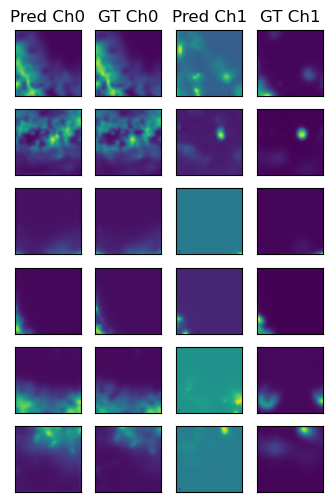

In [16]:
from disentangle.analysis.plot_utils import clean_ax
ncols = predictions.shape[1] + 1
assert nimgs % 2 == 0
nrows = 2*nimgs
dfac = 1
# rgb = target_unnorm.shape[-1]
_,ax = plt.subplots(figsize=(ncols*1*2,nrows*1//2), ncols=ncols*2, nrows=nrows//2)
ax = ax.reshape(nrows,ncols)
for img_idx in range(nimgs):
    for i in range(predictions.shape[1]):
        ax[0+img_idx*2,i].imshow(predictions[img_idx,i,::dfac,::dfac,:nC])
        ax[1+img_idx*2,i].imshow(predictions[img_idx,i,::dfac,::dfac,nC:])

    ax[0+img_idx*2,-1].imshow(targets[img_idx,::dfac,::dfac,:nC])
    ax[1+img_idx*2,-1].imshow(targets[img_idx,::dfac,::dfac,nC:])

ax[0,-1].set_title('GT Ch0')
ax[0,0].set_title('Input')
ax[0,-2].set_title('Pred Ch0')

ax[1,-1].set_title('GT Ch1')
ax[1,0].set_title('Input')
ax[1,-2].set_title('Pred Ch1')

clean_ax(ax)

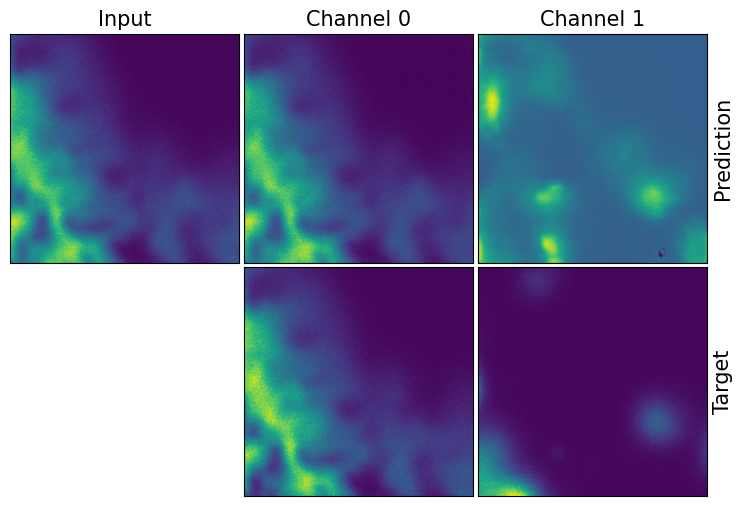

In [17]:
import matplotlib.pyplot as plt 
from disentangle.analysis.plot_utils import clean_ax
img_idx = 0
pred_tmp = predictions[img_idx,-1]
target_tmp = targets[img_idx]
input_tmp = inputs[img_idx]
rgb_ch = target_tmp.shape[-1]

_,ax = plt.subplots(figsize=(9,6),ncols=3,nrows=2)
ax[0,0].set_title('Input', fontsize=15)
ax[1,0].axis('off')



ax[0,1].set_title('Channel 0', fontsize=15)
ax[0,2].set_title('Channel 1', fontsize=15)
ax[0,2].set_ylabel('Prediction', fontsize=15)
ax[1,2].set_ylabel('Target', fontsize=15)
ax[0,2].yaxis.set_label_position("right")
ax[1,2].yaxis.set_label_position("right")


ax[0,0].imshow(input_tmp)
ax[0,1].imshow(pred_tmp[...,:rgb_ch//2])
ax[1,1].imshow(target_tmp[...,:rgb_ch//2])

ax[0,2].imshow(pred_tmp[...,rgb_ch//2:])
ax[1,2].imshow(target_tmp[...,rgb_ch//2:])
clean_ax(ax)
# remove the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

In [18]:
import seaborn as sns
show_hist = False
if show_hist:
    ncols = predictions.shape[-1]
    _,ax = plt.subplots(figsize=(3*ncols,3),ncols=ncols)
    for ch_idx in range(ncols):
        sns.histplot(targets[:,...,ch_idx].reshape(-1,), label='target',ax=ax[ch_idx])
        sns.histplot(predictions[:,-1,...,ch_idx].reshape(-1,), label='prediction', ax=ax[ch_idx])
    plt.legend()
    plt.tight_layout()

## Evaluation on whole dataset

In [19]:
from core.psnr import PSNR
from collections import defaultdict
from tqdm import tqdm

psnr_dict = defaultdict(list)
all_predictions = []
all_targets = []
for i in tqdm(range(len(val_set))):
    data_ith = val_set[i]
    diffusion_data = get_input_dict({'input': torch.Tensor(data_ith['input'][None]), 'target': torch.Tensor(data_ith['target'][None])})
    diffusion_data['input'] = diffusion_data['input']
    diffusion_data['target'] = diffusion_data['target']

    input_unnorm, target_unnorm, pred_unnorm = get_prediction_raw(diffusion_data)
    all_predictions.append(pred_unnorm[-1:].astype(np.float32))
    all_targets.append(target_unnorm)
    
    ch0_psnr = torch.mean(PSNR(pred_unnorm[-1,...,:nC].transpose(2,0,1), target_unnorm[0,...,:nC].transpose(2,0,1))).item()
    ch1_psnr = torch.mean(PSNR(pred_unnorm[-1,...,nC:].transpose(2,0,1), target_unnorm[0,...,nC:].transpose(2,0,1))).item()
    psnr_dict['ch0'].append(ch0_psnr)
    psnr_dict['ch1'].append(ch1_psnr)
    

inference time step: 100%|██████████| 1/1 [00:00<00:00, 69.86it/s]


100%|██████████| 2400/2400 [02:48<00:00, 14.28it/s]


In [20]:
import gc; gc.collect()

55358

In [21]:
predictions = np.concatenate(all_predictions, axis=0)
predictions.shape

(2400, 2, 256, 256)

In [22]:
pred_stitched = stitch_predictions(predictions, val_set.tile_manager)

[96, 700, 700, 2]


In [23]:
max_val = None
# ch0 = np.stack(train_set._data_dict[0])
# ch1 = np.stack(train_set._data_dict[1])
# target_stitched_train = np.stack([ch0,ch1], axis=-1)
# max_val = np.quantile(target_stitched_train,0.995)


In [24]:
ch0 = np.stack(val_set._data_dict[0])
ch1 = np.stack(val_set._data_dict[1])
target_stitched = np.stack([ch0,ch1], axis=-1)
if max_val is not None:
    target_stitched[target_stitched>max_val] = max_val
    pred_stitched[pred_stitched>max_val] = max_val
target_stitched.shape

(96, 700, 700, 2)

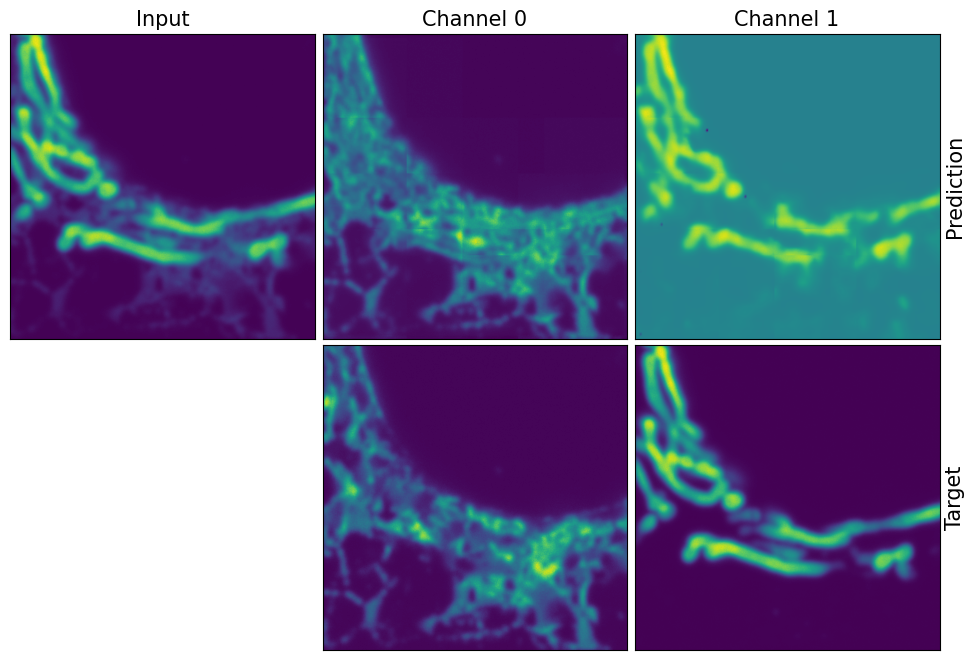

In [25]:
_,ax = plt.subplots(figsize=(12,8),ncols=3,nrows=2)
img_idx = 10
ax[0,0].imshow(target_stitched[img_idx,...,:nC] + target_stitched[img_idx,...,nC:])
ax[0,1].imshow(pred_stitched[img_idx,...,:nC])
ax[0,2].imshow(pred_stitched[img_idx,...,nC:])
ax[1,1].imshow(target_stitched[img_idx,...,:nC])
ax[1,2].imshow(target_stitched[img_idx,...,nC:])

ax[0,0].set_title('Input', fontsize=15)
ax[0,1].set_title('Channel 0', fontsize=15)
ax[0,2].set_title('Channel 1', fontsize=15)
ax[0,2].set_ylabel('Prediction', fontsize=15)
ax[1,2].set_ylabel('Target', fontsize=15)
ax[0,2].yaxis.set_label_position("right")
ax[1,2].yaxis.set_label_position("right")

ax[1,0].axis('off')

# reduce the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)
clean_ax(ax)

In [26]:
from core.psnr import RangeInvariantPsnr
ch0psnr, ch1psnr = [RangeInvariantPsnr(target_stitched[...,i]*1.0, pred_stitched[...,i]) for i in range(2)]
msg_psnr = f'PSNR: N{num_timesteps} '
msg_psnr += f'Ch0: {ch0psnr.mean().item():.1f} +- {ch0psnr.std().item()/np.sqrt(len(ch0psnr)):.1f}\t'
msg_psnr += f'Ch1: {ch1psnr.mean().item():.1f} +- {ch1psnr.std().item()/np.sqrt(len(ch1psnr)):.1f}'
print(msg_psnr)


PSNR: N1 Ch0: 24.4 +- 0.3	Ch1: 26.0 +- 0.2


In [27]:
from collections import defaultdict
import lpips
loss_fn_vgg = lpips.LPIPS(net='alex').cuda()

def compute_lpips(target, pred):
    # NHWC -> NCHW
    target = target.transpose(0,3,1,2) # channel is  in the second dimension
    pred = pred.transpose(0,3,1,2)    
    output = defaultdict(list)
    for ch_idx in range(target.shape[1]):
        tar_tmp = target[:,ch_idx:ch_idx+1]
        pred_tmp = pred[:,ch_idx:ch_idx+1]
        tar_tmp = np.repeat(tar_tmp, 3, axis=1)
        pred_tmp = np.repeat(pred_tmp, 3, axis=1)
        max_val = tar_tmp.max()
        min_val = tar_tmp.min()
        tar_tmp  = 2*(tar_tmp - min_val)/(max_val - min_val) - 1
        pred_tmp = 2*(pred_tmp - min_val)/(max_val - min_val) - 1
        output[ch_idx] = [loss_fn_vgg(torch.Tensor(tar_tmp[i]).cuda(), torch.Tensor(pred_tmp[i]).cuda()).item() for i in range(tar_tmp.shape[0])]
    return output

lpips_dict = compute_lpips(target_stitched, pred_stitched)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [28]:
msg_lpips = f'LPIPS: N{num_timesteps} '
for k,v in lpips_dict.items():
    msg_lpips += f'Ch{k}: {np.mean(v):.3f}+-{np.std(v)/np.sqrt(len(v)):.3f}\t'

print(msg_lpips)

LPIPS: N1 Ch0: 0.084+-0.003	Ch1: 0.096+-0.002	


In [29]:
print(ckpt, 'RealInput:',enable_real_input)
print(msg_psnr)
print(msg_lpips)

2501/COSEM_jrc-hela-joint_indi-l1/13 RealInput: True
PSNR: N1 Ch0: 24.4 +- 0.3	Ch1: 26.0 +- 0.2
LPIPS: N1 Ch0: 0.084+-0.003	Ch1: 0.096+-0.002	


In [30]:
break here

SyntaxError: invalid syntax (760050616.py, line 1)

In [45]:
# PSNR: N5 Ch0: 32.2 +- 0.9	Ch1: 34.5 +- 0.6
# LPIPS: N5 Ch0: 0.042+-0.005	Ch1: 0.042+-0.004	

# PSNR: N1 Ch0: 33.8 +- 0.8	Ch1: 36.0 +- 0.8
# LPIPS: N1 Ch0: 0.050+-0.005	Ch1: 0.059+-0.005	


In [46]:
indi_model = diffusion.netG
dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=nimgs,
            shuffle=True,
            num_workers=0,
            pin_memory=True)
for data in dloader:
    break


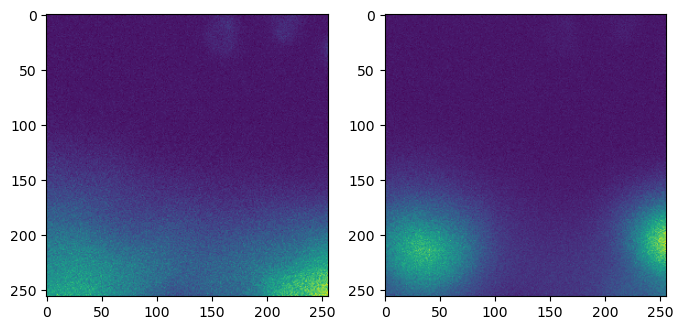

In [47]:
mixing_t = 0.15
img_idx = 1
inp_indi0 = data['target'][img_idx:img_idx+1,:1]*(1-mixing_t) + data['target'][img_idx:img_idx+1,1:2]*mixing_t
inp_indi1 = data['target'][img_idx:img_idx+1,1:2]*(1-mixing_t) + data['target'][img_idx:img_idx+1,:1]*mixing_t
_,ax = plt.subplots(figsize=(8,4),ncols=2)
ax[0].imshow(inp_indi0[0,0].cpu())
ax[1].imshow(inp_indi1[0,0].cpu())

In [48]:
predicted_t = mixing_t

In [49]:
ch1 = indi_model.indi1.p_sample_loop(inp_indi0.cuda(), clip_denoised=True, continuous=False, num_timesteps=1, t_float_start=predicted_t)
ch2 = indi_model.indi2.p_sample_loop(inp_indi1.cuda(), clip_denoised=True, continuous=False, num_timesteps=1, t_float_start=predicted_t)


TypeError: p_sample_loop() got an unexpected keyword argument 'continuous'

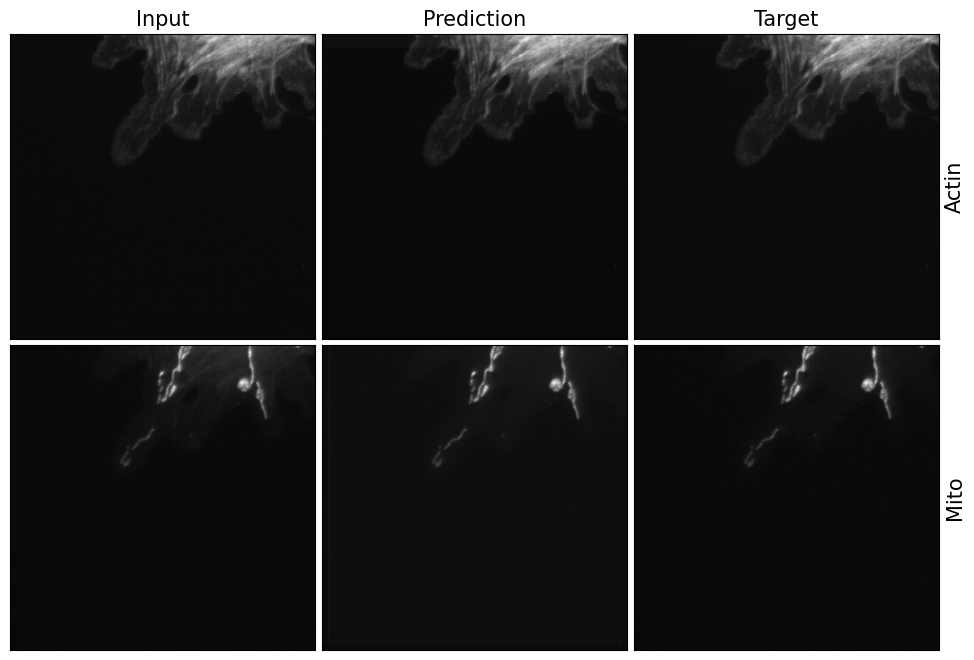

In [39]:
from disentangle.analysis.plot_utils import clean_ax

_,ax = plt.subplots(figsize=(12,8),nrows=2,ncols=3)
ax = ax.T
ax[0,0].imshow(inp_indi0[0,0], cmap='gray')
ax[0,1].imshow(inp_indi1[0,0], cmap='gray')
ax[1,0].imshow(ch1[0].cpu(), cmap='gray')
ax[1,1].imshow(ch2[0].cpu(), cmap='gray')

ax[2,0].imshow(data['target'][img_idx,0], cmap='gray')
ax[2,1].imshow(data['target'][img_idx,1], cmap='gray')
clean_ax(ax)
# remove the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)
ax = ax.T
ax[0,0].set_title('Input', fontsize=15, )
ax[0,1].set_title('Prediction', fontsize=15, )
ax[0,2].set_title('Target', fontsize=15, )
ax[0,2].set_ylabel('Actin', fontsize=15, )
ax[1,2].set_ylabel('Mito', fontsize=15, )

ax[0,2].yaxis.set_label_position("right")
ax[1,2].yaxis.set_label_position("right")

# save the figure to file with 200 dpi
# plt.savefig(f'indi_prediction_{mixing_t}.png', dpi=200)

## Using Classifier to predict the time.

In [31]:
from model.ddpm_modules.time_predictor import TimePredictor
from data.time_predictor_dataset import compute_input_normalization_dict
# for normalization
classifier_T = 100
input_normalization_dict = compute_input_normalization_dict(val_set._data_dict, classifier_T, val_set._mean_target, val_set._std_target)

def min_max_normalize(img, t_float):
    assert 0 <= t_float < 1
    t_int = int(t_float * classifier_T)
    t_min, t_max = input_normalization_dict[t_int]
    return 2*(img - t_min)/(t_max - t_min) -1

classifier_ckpt = '/group/jug/ashesh/training/diffsplit/2410/Hagen-UnetClassifier-l2/8'
opt = load_config(classifier_ckpt)
model_opt = opt['model']
model = TimePredictor(
    in_channel=model_opt['unet']['in_channel'],
    out_channel=model_opt['unet']['out_channel'],
    norm_groups=model_opt['unet']['norm_groups'],
    inner_channel=model_opt['unet']['inner_channel'],
    channel_mults=model_opt['unet']['channel_multiplier'],
    attn_res=model_opt['unet']['attn_res'],
    res_blocks=model_opt['unet']['res_blocks'],
    dropout=model_opt['unet']['dropout'],
    image_size=opt['datasets']['patch_size'],
    )
model = model.cuda()
# load checkpoint
model.load_state_dict(torch.load(os.path.join(classifier_ckpt,'best_time_predictor.pth')), strict=True)

def get_time_prediction_ch0(input_ch0):
    with torch.no_grad():
        pred_t_0 = model(input_ch0.cuda())
    pred_t_0 = 1 - pred_t_0
    return pred_t_0

def get_time_prediction_ch1(input_ch1):
    with torch.no_grad():
        pred_t_1 = model(input_ch1.cuda())
    return pred_t_1



100%|██████████| 101/101 [00:13<00:00,  7.57it/s]


In [32]:
indi_model = diffusion.netG
dloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=nimgs,
            shuffle=True,
            num_workers=0,
            pin_memory=True)
for data in dloader:
    break


In [33]:
mixing_t = 0.1
img_idx = 2
inp_indi0 = data['target'][:,:1]*(1-mixing_t) + data['target'][:,1:2]*mixing_t
inp_indi1 = data['target'][:,1:2]*(1-mixing_t) + data['target'][:,:1]*mixing_t

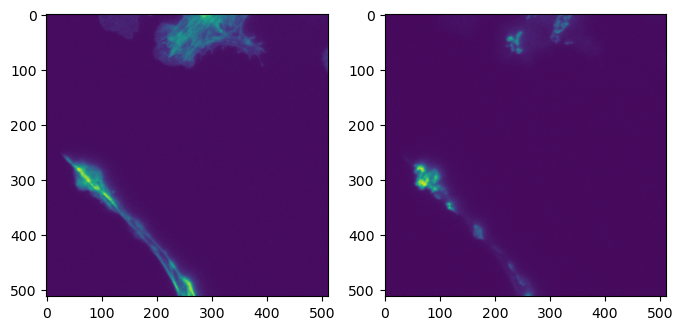

In [34]:
img_idx = 1
_,ax = plt.subplots(figsize=(8,4),ncols=2)
ax[0].imshow(inp_indi0[img_idx,0])
ax[1].imshow(inp_indi1[img_idx,0])

In [36]:
pred_ch1 = []
pred_ch2 = []
model.eval()
with torch.no_grad():
    pred_t_0 = get_time_prediction_ch0(min_max_normalize(inp_indi0, 1-mixing_t).cuda())
    pred_t_1 = get_time_prediction_ch1(min_max_normalize(inp_indi1, mixing_t).cuda())
    for batch_idx in range(len(inp_indi0)):
        ch1 = indi_model.indi1.inference(inp_indi0[batch_idx:batch_idx+1].cuda(), 
                                             continuous=False, num_timesteps=None, t_float_start=pred_t_0[batch_idx].item())
        pred_ch1.append(ch1.cpu().numpy())
        ch2 = indi_model.indi2.inference(inp_indi1[batch_idx:batch_idx+1].cuda(), 
                                             continuous=False, num_timesteps=1, t_float_start=pred_t_1[batch_idx].item())
        pred_ch2.append(ch2.cpu().numpy())

inference time step: 100%|██████████| 1/1 [00:00<00:00, 71.19it/s]


In [39]:
pred_ch2[0].shape

(1, 1, 512, 512)

Text(0.5, 1.0, 'Mito')

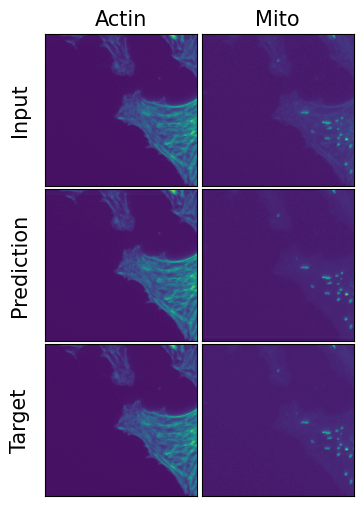

In [40]:
from disentangle.analysis.plot_utils import clean_ax
img_idx = 0

_,ax = plt.subplots(figsize=(4,6),nrows=3,ncols=2)

ax[0,0].imshow(inp_indi0[img_idx,0], )
ax[0,1].imshow(inp_indi1[img_idx,0], )
ax[1,0].imshow(pred_ch1[img_idx][0,0], )
ax[1,1].imshow(pred_ch2[img_idx][0,0], )

ax[2,0].imshow(data['target'][img_idx,0], )
ax[2,1].imshow(data['target'][img_idx,1], )
clean_ax(ax)
# remove the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)
ax[0,0].set_ylabel('Input', fontsize=15, )
ax[1,0].set_ylabel('Prediction', fontsize=15, )
ax[2,0].set_ylabel('Target', fontsize=15, )
ax[0,0].set_title('Actin', fontsize=15, )
ax[0,1].set_title('Mito', fontsize=15, )

# ax[0,2].yaxis.set_label_position("right")
# ax[1,2].yaxis.set_label_position("right")

# save the figure to file with 200 dpi
# plt.savefig(f'indi_prediction_{mixing_t}.png', dpi=200)

## Qualitative Evaluation using the classifier.

Here, we want to see the performance of both indi1 and indi2 predictions. when the input has mostly channel 1, then indi1 will be more accurate. When the input has mostly channel 2, then indi2 will be more accurate.

In [51]:
import gc; gc.collect()

60494

In [52]:
# mixing_t_ood = 0.1
# num_timesteps = 2
# data = val_set[4]
# inp_indi1 = data['target'][:1]*(1-mixing_t_ood) + data['target'][1:2]*mixing_t_ood
# inp_indi2 = data['target'][1:2]*(1-mixing_t_ood) + data['target'][:1]*mixing_t_ood
# inp_indi1 = torch.Tensor(inp_indi1[None]).cuda()
# inp_indi2 = torch.Tensor(inp_indi2[None]).cuda()
# with torch.no_grad():
#     pred_t_1 = [mixing_t_ood] # get_time_prediction_ch0(inp_indi1.cuda()).detach().cpu().numpy() #
#     pred_t_2 = [mixing_t_ood] # get_time_prediction_ch1(inp_indi2.cuda()).detach().cpu().numpy() #[mixing_t_ood] #
#     pred_ch0 = indi_model.inference(inp_indi1, continuous=False, num_timesteps=num_timesteps, t_float_start=pred_t_1[0])
#     pred_ch1 = indi_model.inference(inp_indi2, continuous=False, num_timesteps=num_timesteps, t_float_start=pred_t_2[0])

# _,ax = plt.subplots(figsize=(16,8),ncols=4,nrows=2)
# ax[0,0].imshow(inp_indi0[0,0].cpu())
# ax[1,0].imshow(inp_indi1[0,0].cpu())

# ax[0,1].imshow(pred_ch0[0,0].cpu().numpy())
# ax[1,1].imshow(pred_ch0[0,1].cpu().numpy())

# ax[0,2].imshow(pred_ch1[0,0].cpu().numpy())
# ax[1,2].imshow(pred_ch1[0,1].cpu().numpy())


# ax[0,3].imshow(data['target'][0])
# ax[1,3].imshow(data['target'][1])
# ax[0,0].set_title('Input', fontsize=15)
# ax[0,1].set_title('Indi0 Predictions', fontsize=15)
# ax[0,2].set_title('Indi1 Predictions', fontsize=15)
# ax[0,3].set_title('Target', fontsize=15)

## Quantitative Evaluation using the classifier.
Here, we also inspect the effect of MMSE count.

In [94]:
from core.psnr import PSNR
from collections import defaultdict
from tqdm import tqdm

mixing_t_ood = 0.5
num_timesteps = 5
psnr_dict_ood = defaultdict(list)
mmse_count = 5
all_targets_ood = []
all_inputs_ood = []
eps = 1e-6

pred_t_0_arr = []
pred_t_1_arr = []
all_mmse_predictions_ood = []
for mmse_idx in range(mmse_count):
    all_predictions_ood = []
    for i in tqdm(range(len(val_set))):
        data = val_set[i]
        inp_indi0 = data['target'][:1]*(1-mixing_t_ood) + data['target'][1:2]*mixing_t_ood
        inp_indi1 = data['target'][1:2]*(1-mixing_t_ood) + data['target'][:1]*mixing_t_ood
        all_inputs_ood.append(np.concatenate([inp_indi0, inp_indi1], axis=0)[None])
        inp_indi0 = torch.Tensor(inp_indi0[None]).cuda()
        inp_indi1 = torch.Tensor(inp_indi1[None]).cuda()
        pred_t_0 = [mixing_t_ood] #get_time_prediction_ch0(min_max_normalize(inp_indi0, 1-mixing_t_ood).cuda()).detach().cpu().numpy() #[mixing_t_ood] #
        pred_t_1 = [mixing_t_ood] #get_time_prediction_ch1(min_max_normalize(inp_indi1, mixing_t_ood).cuda()).detach().cpu().numpy() #[mixing_t_ood] #
        pred_t_0= pred_t_0[0]
        pred_t_1= pred_t_1[0]

        if pred_t_0 < eps:
            pred_t_0 = 0
        if pred_t_1 < eps:
            pred_t_1 = 0
        if pred_t_0 > 1:
            pred_t_0 = 1
        if pred_t_1 > 1:
            pred_t_1 = 1
        
        pred_t_0_arr.append(pred_t_0)
        pred_t_1_arr.append(pred_t_1)

        # pred_ch0 = indi_model.inference(inp_indi0,clip_denoised=True, continous=False, t_float_start=np.mean(pred_t_0_arr[-10:]), num_timesteps=num_timesteps)
        # pred_ch1 = indi_model.inference(inp_indi1,clip_denoised=True, continous=False, t_float_start=np.mean(pred_t_1_arr[-10:]), num_timesteps=num_timesteps)
        pred_ch0 = indi_model.inference(inp_indi0, continuous=False, t_float_start=pred_t_0, num_timesteps=num_timesteps)
        pred_ch1 = indi_model.inference(inp_indi1, continuous=False, t_float_start=pred_t_1, num_timesteps=num_timesteps)
        
        # we ignore the other channel prediction. TODO: inspect that as well.  
        pred_ch0 = pred_ch0[:,0]
        pred_ch1 = pred_ch1[:,1]

        # old way of prediction
        # pred_ch0 = indi_model.indi1.p_sample_loop(inp_indi0, clip_denoised=True, continuous=False, num_timesteps=1, t_float_start=pred_t_0[0])
        # pred_ch1 = indi_model.indi2.p_sample_loop(inp_indi1, clip_denoised=True, continuous=False, num_timesteps=1, t_float_start=pred_t_1[0])
        
        pred = np.concatenate([pred_ch0.cpu().numpy(), pred_ch1.cpu().numpy()], axis=0)
        pred_unnorm = pred * norm_dict['std_target'] + norm_dict['mean_target']
        tar_unnorm = data['target'] * norm_dict['std_target'] + norm_dict['mean_target']
        if mmse_idx == 0:
            all_targets_ood.append(tar_unnorm[None])
        
        all_predictions_ood.append(pred_unnorm[None])

    all_predictions_ood = np.concatenate(all_predictions_ood, axis=0)
    all_mmse_predictions_ood.append(all_predictions_ood)

all_targets_ood = np.concatenate(all_targets_ood, axis=0)
all_inputs_ood = np.concatenate(all_inputs_ood, axis=0)

pred_t_0_arr = np.array(pred_t_0_arr)
pred_t_1_arr = np.array(pred_t_1_arr)


  0%|          | 0/490 [00:00<?, ?it/s]

100%|██████████| 490/490 [03:25<00:00,  2.38it/s]


In [95]:
all_predictions_ood.shape

(490, 2, 512, 512)

In [96]:
len(all_mmse_predictions_ood)

5

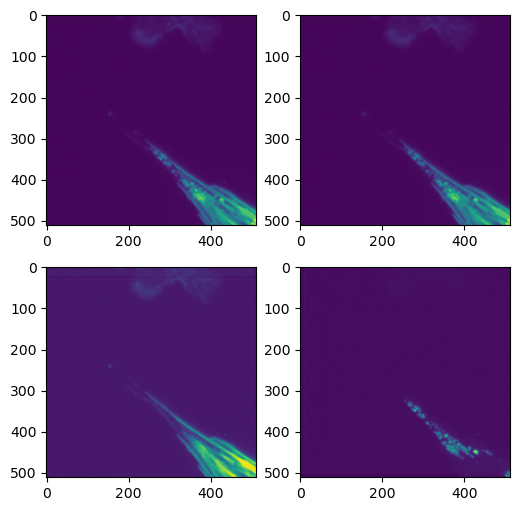

In [97]:
_,ax = plt.subplots(figsize=(6,6),nrows=2,ncols=2)
ax[0,0].imshow(all_inputs_ood[1,0])
ax[0,1].imshow(all_inputs_ood[1,1])
ax[1,0].imshow(all_predictions_ood[1,0])
ax[1,1].imshow(all_predictions_ood[1,1])

In [98]:
np.min(pred_t_1_arr)

0.5

In [99]:
mmse_pred = 0 
for i in range(mmse_count):
    mmse_pred += all_mmse_predictions_ood[i]/mmse_count

In [100]:
from data.tile_stitcher import stitch_predictions

pred_stitched_ood = stitch_predictions(mmse_pred, val_set.tile_manager)
tar_stitched_ood = stitch_predictions(all_targets_ood, val_set.tile_manager)
# inputs_stitched_ood = stitch_predictions(all_inputs_ood, val_set.tile_manager)
# target_stitched_ood = np.stack(val_set._data_dict, axis=-1)

[10, 2048, 2048, 2]
[10, 2048, 2048, 2]


In [101]:
from core.psnr import RangeInvariantPsnr
ch0psnr, ch1psnr = [RangeInvariantPsnr(tar_stitched_ood[...,i]*1.0, pred_stitched_ood[...,i]) for i in range(2)]
msg_psnr = f'T:{num_timesteps} W:{mixing_t_ood} M:{mmse_count} PSNR: N{num_timesteps} '
msg_psnr += f'Ch0: {ch0psnr.mean().item():.1f} +- {ch0psnr.std().item()/np.sqrt(len(ch0psnr)):.1f}\t'
msg_psnr += f'Ch1: {ch1psnr.mean().item():.1f} +- {ch1psnr.std().item()/np.sqrt(len(ch1psnr)):.1f}'
print(msg_psnr)


T:5 W:0.5 M:5 PSNR: N5 Ch0: 32.3 +- 0.9	Ch1: 34.6 +- 0.7


In [102]:
# predicted t

# actual t
# T:1 W:0.5 M:1 PSNR: N1 Ch0: 33.8 +- 0.8	Ch1: 36.0 +- 0.8
# T:1 W:0.5 M:5 PSNR: N1 Ch0: 33.9 +- 0.8	Ch1: 36.0 +- 0.8

# T:2 W:0.5 M:1 PSNR: N2 Ch0: 33.0 +- 0.9	Ch1: 35.4 +- 0.7
# T:2 W:0.5 M:5 PSNR: N2 Ch0: 33.1 +- 0.9	Ch1: 35.5 +- 0.7

# T:5 W:0.5 M:1 PSNR: N5 Ch0: 32.2 +- 0.9	Ch1: 34.5 +- 0.7
# T:5 W:0.5 M:5 PSNR: N5 Ch0: 32.3 +- 0.9	Ch1: 34.6 +- 0.7

